# **INFO6147 Deep Learning with Pytorch Capstone Project**
**Instructor:** Dr. Mohammed Yousefhussien

**Author of Notebook:** Arjun Unadkat

**Date last modified:** 04/12/2024

NB: This project requires GPU to run the code in order to minimize the execution time

---


**Introduction and Background**

According to the Canadian Lung Association, Pneumonia is an infection-related swelling
(inflammation) of one or both lungs. Pneumonia can be caused by a wide variety of pathogens,
such as bacteria, viruses, and fungus. These bacteria have the ability to settle in your lungs'
alveoli, or air sacs, after being inhaled. The bacteria may spread deep throughout your lungs and
get past your body's natural defences. The lungs' air sacs, or alveoli, swell with mucus and pus
after an infection. The air sacs become less flexible as a result of this swelling (inflammation),
which also prevents oxygen from adequately entering your bloodstream.
In Canada, influenza and pneumonia caused 15.4 deaths per 100,000 people in 2022. Tens of
thousands of Canadians are admitted to hospitals each year due to pneumonia. In Canada,
more over 63,000 ER visits were for pneumonia in 2021–2022, which is a significant drop from
the figures from 2010–2020.

**Dataset**

To tackle this problem, I will use the following dataset provided by the Radiological Society of
North America:
https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge

Acknowledgements: Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

Original Source: https://nihcc.app.box.com/v/ChestXray-NIHCC

This dataset consists of -
26,684 X-Ray images:
*  20, 672 images without
pneumonia
*  6, 012 images with pneumonia

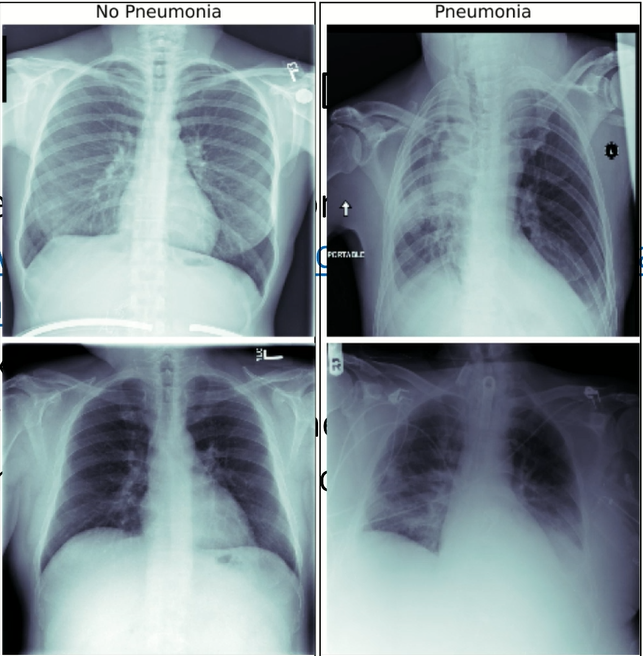

# Preprocessing

**Imports:**
*   pydicom for reading dicom files
*   pathlib for convenient path handling
*   numpy for storing the actual images and other calculations
*   pandas to read the provided labels
*   matplotlib for visualizing some images
*   tqdm for nice progress bar
*   time to log the time it takes for certain code to run



In [1]:
!pip install pydicom
!pip install torch
!pip install torchvision
!pip install pytorch_lightning
!pip install torchmetrics
!pip install pytorch_lightning
!pip install pandas
!pip install wheel
!pip install matplotlib
!pip install opencv-python
!pip install tqdm

In [2]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torchmetrics
import torchvision.models as models
import torch.nn as nn
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from pathlib import Path
from torchvision import transforms
from torch.optim import Adam
from torch.optim import SGD
from torchvision.transforms import functional as F

Firstly we read the csv file containing the labels and remove duplicates as we are only interested in the binary label

In [3]:
# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
labels = pd.read_csv("rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [5]:
labels.head(-10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30212,c1c3ec5d-20ba-42f7-91f9-48032d97ffc9,NaN,NaN,NaN,NaN,0
30213,c1ca4417-83a6-43a7-a9bf-7d9587e7f14f,NaN,NaN,NaN,NaN,0
30214,c1cddf32-b957-4753-acaa-472ab1447e86,269.0,416.0,193.0,285.0,1
30215,c1cddf32-b957-4753-acaa-472ab1447e86,766.0,475.0,135.0,213.0,1


In [6]:
labels = labels.drop_duplicates("patientId")

In [7]:
labels.head(-10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30207,c1718678-44af-407f-829a-fc65bc854094,NaN,NaN,NaN,NaN,0
30208,c18d1138-ba74-4af5-af21-bdd4d2c96bb5,646.0,386.0,141.0,206.0,1
30210,c196ce23-f37c-4ab3-a9ce-ea8ede90e09c,NaN,NaN,NaN,NaN,0
30211,c19b8a3b-ab4e-4a73-8e13-ec0a84b6b6c7,NaN,NaN,NaN,NaN,0


Defining the path to the dicom files and also the path where we want to store our processed resized numpy files

In [8]:
ROOT_PATH = Path("rsna-pneumonia-detection-challenge/stage_2_train_images")
SAVE_PATH = Path("rsna-pneumonia-detection-challenge/ProcessedTest/")

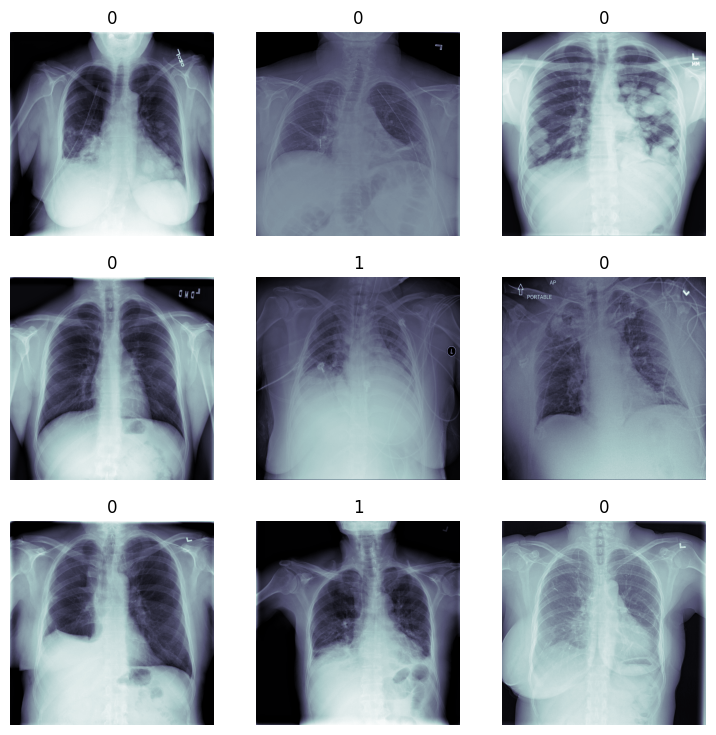

In [9]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.dcmread(dcm_path).pixel_array

        label = labels["Target"].iloc[c]

        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].axis("off")
        axis[i][j].set_title(label)
        c+=1

The above is a sample of the images in the dataset along with their labels. Notice we can see a couple of images with labels 1 which indicate that there is pneumonia classification features present

To process our data in a more manageable way in the Dataloader, we transform X-Ray images in DICOM format to numpy arrays format. Thereafter, we calculate the mean and standard deviation for pixels across the whole dataset to use it for normalization purposes. After that, the created numpy images are divided into two folders according to their binary label:
*   0: X-Rays, which do not demonstrate pneumonia
*   1: X-Rays showing pneumonia

To accomplish the task, we loop through the patient ids and concatenate the patient id with ROOT_PATH. It is then possible to save updated healthy and ill pneumonia images automatically injecting their current state’s file path, ‘0’ number or ‘1’ number respectively in each folder. This provides a quick solution since we are able to utilize the build-in torchvision DatasetFolder that is easy to implement in case we need to read files. In this case, all the images are transformed by the maximum pixel value in the dataset which is 255, and all the images have an output size of 224x224. In order to calculate dataset mean and standard deviation, the sum of pixel values as well as sum of the squared pixel values are computed for each subject. This is useful when trying to calculate overall mean and standard deviation and there is a need to conserve the space occupied by the entire dataset in memory.



In [10]:
sums = 0
sums_squared = 0
start_time = time.time()
for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix
    
    # Read the dicom file with pydicom and standardize the array
    dcm = pydicom.dcmread(dcm_path).pixel_array / 255  
        
    # Resize the image as 1024x1024 is way to large
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
    # Retrieve the corresponding label
    label = labels.Target.iloc[c]
    
    # 4/5 train split, 1/5 val split
    train_or_val = "train" if c < 24000 else "val" 
        
    current_save_path = SAVE_PATH/train_or_val/str(label) # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory
    
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
    if train_or_val == "train":  # Only use train data to compute dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

# Print elapsed time
print(f'\nDuration: {(time.time() - start_time) / 60:.2f} minutes')

  0%|          | 0/26684 [00:00<?, ?it/s]


Duration: 7.37 minutes


In [11]:
mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.0853271484375, STD: 0.2340087890625


# Training

We start by preparing the dataset. The DatasetFolder from torchvision can be utilized for this purpose: It enables to specify only the source directory and get a dataset type object, which has all files in this directory and the name of the directory as class name.

We only need to specify one loader function, load_file: the file which defines how the files will be in the future. This is quite comfortable because we have only to deal with the numpy files that we have already created and stored. Also, a fileType list needs to be created, specifying the file types that will be tolerated (for our purposes, just "npy").

When loading .npy files, sometimes we find that too many files being accessed simultaneously and slow disk read speeds will cause a delay. To overcome this we implement preloading the data into memory. Instead of reading the files on the go with np.load, we can actually preload the dataset into memory. This avoids repeated disk access. After which we have to update the Dataset class to use this preloaded data.

At last we can specify a series of transformations for Data Augmentation and Normalization as well.

We take:

*   RandomResizedCrops, which performs a random crop of the image and resizes the crop to the same aspect ratio as the target size (224*224).
*   Random Rotations of the image with an angle extended from –5 degrees to +5 degrees;
*   Random Translation whose maximum value is 5 percent;
*   Random Scaling within the given seams, 0.9 and 1.1 to an original image size.

In [12]:
# Preload dataset into memory
def preload_data(data_dir):
    data = []
    labels = []
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                data.append(np.load(file_path).astype(np.float32))
                labels.append(int(label_dir))
    return data, labels

# Preloading the train and validation datasets
print("Preloading train dataset")
train_data, train_labels = preload_data("rsna-pneumonia-detection-challenge/ProcessedTest/train/")
print(f"Loaded {len(train_data)} training samples.")

print("Preloading validation dataset")
val_data, val_labels = preload_data("rsna-pneumonia-detection-challenge/ProcessedTest/val/")
print(f"Loaded {len(val_data)} validation samples.")

Preloading train dataset
Loaded 24000 training samples.
Preloading validation dataset
Loaded 2684 validation samples.


In [13]:
# Custom Dataset Class
class PreloadedDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


In [14]:
# Define transformations and performing data augmentation
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),  # Use mean and std from preprocessing
    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1)),
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([mean], [std]),  # Use mean and std from preprocessing
])

In [15]:
# Create Datasets
train_dataset = PreloadedDataset(train_data, train_labels, transform=train_transforms)
val_dataset = PreloadedDataset(val_data, val_labels, transform=val_transforms)


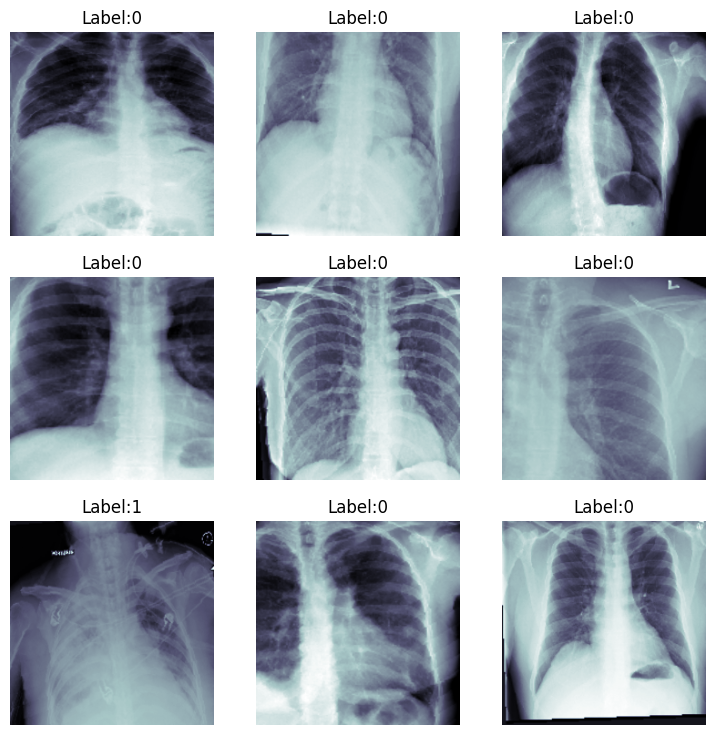

In [16]:
# Visualize a few samples
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        random_index = np.random.randint(0, len(train_dataset))
        x_ray, label = train_dataset[random_index]
        axis[i][j].axis("off")
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

The above is a sample of random images after data augmentation. We can still somewhat see a clear image of the two lungs which is the area we can use to classify whether the patient has pneumonia or not.

In [17]:
# Data Loaders
batch_size = 64
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images.")

There are 24000 train images and 2684 val images.


In [18]:
# Access the dataset directly for debugging
print("\nTesting dataset directly...")
for idx in range(5):
    img, label = train_dataset[idx]  
    print(f"Sample {idx + 1}: Image shape: {img.shape}, Label: {label}")
print("Dataset is working correctly!\n")


Testing dataset directly...
Sample 1: Image shape: torch.Size([1, 224, 224]), Label: 0
Sample 2: Image shape: torch.Size([1, 224, 224]), Label: 0
Sample 3: Image shape: torch.Size([1, 224, 224]), Label: 0
Sample 4: Image shape: torch.Size([1, 224, 224]), Label: 0
Sample 5: Image shape: torch.Size([1, 224, 224]), Label: 0
Dataset is working correctly!



In [19]:
# Check DataLoader for debugging
print("\nChecking DataLoader...")
for i, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {i + 1}: Input shape: {inputs.shape}, Labels shape: {labels.shape}")
    break
print("DataLoader is working correctly!\n")


Checking DataLoader...
Batch 1: Input shape: torch.Size([64, 1, 224, 224]), Labels shape: torch.Size([64])
DataLoader is working correctly!



In [20]:
# Define Pneumonia Model using ResNet18
class PneumoniaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")
        self.model.conv1 = nn.Conv2d(
            in_channels=1,  # Single-channel input as our images are greyscale
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
            bias=False
        )
        nn.init.kaiming_normal_(self.model.conv1.weight, mode="fan_out", nonlinearity="relu")
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)  # Binary classification

    def forward(self, x):
        return self.model(x)


In [21]:
# Training function
def train(epoch, model, train_loader, optimizer, loss_fn, device, train_losses, train_acc):
    model.train()
    correct = 0
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data).squeeze(1)
        loss = loss_fn(output, target.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(output) > 0.5).int()  # Sigmoid to convert logits to probabilities
        correct += preds.eq(target.int()).sum().item()

        # Print training progress every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

    # Compute metrics for the epoch
    accuracy = 100. * correct / len(train_loader.dataset)
    avg_loss = total_loss / len(train_loader)

    # Append metrics to tracking lists
    train_losses.append(avg_loss)
    train_acc.append(accuracy)

    print(f"Train Epoch: {epoch}, Average Loss: {avg_loss:.4f}, Accuracy: {correct}/{len(train_loader.dataset)} ({accuracy:.2f}%)")


# Evaluation function
def evaluate(model, val_loader, loss_fn, device, val_losses, val_acc):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            output = model(data).squeeze(1)
            test_loss += loss_fn(output, target.float()).item()
            preds = (torch.sigmoid(output) > 0.5).int()
            correct += preds.eq(target.int()).sum().item()

    # Compute metrics for the epoch
    test_loss /= len(val_loader)  # Average batch loss
    accuracy = 100. * correct / len(val_loader.dataset)

    # Append metrics to tracking lists
    val_losses.append(test_loss)
    val_acc.append(accuracy)

    print(f"\nValidation set: Average Loss: {test_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} "
          f"({accuracy:.2f}%)\n")
    return test_loss, accuracy



In [22]:
# Instantiate model, optimizer, and loss function
model = PneumoniaModel().to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
pos_weight = torch.tensor([2.0]).to(device)  # Adjust pos_weight for class imbalance
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [23]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

In [24]:
# Train and validate the model
n_epochs = 5
best_val_loss = float("inf")
start_time = time.time()

for epoch in range(1, n_epochs + 1):
    train(epoch, model, train_loader, optimizer, loss_fn, device, train_losses, train_acc)
    val_loss, val_acc_epoch = evaluate(model, val_loader, loss_fn, device, val_losses, val_acc)


print("\nTraining Complete!")
print(f'\nDuration: {(time.time() - start_time) / 60:.2f} minutes')

Train Epoch: 1 [6336/24000 (26%)]	Loss: 0.733036
Train Epoch: 1 [12736/24000 (53%)]	Loss: 0.450292
Train Epoch: 1 [19136/24000 (80%)]	Loss: 0.590956
Train Epoch: 1, Average Loss: 0.6159, Accuracy: 18704/24000 (77.93%)

Validation set: Average Loss: 0.5123, Accuracy: 2238/2684 (83.38%)

Train Epoch: 2 [6336/24000 (26%)]	Loss: 0.463338
Train Epoch: 2 [12736/24000 (53%)]	Loss: 0.524424
Train Epoch: 2 [19136/24000 (80%)]	Loss: 0.595535
Train Epoch: 2, Average Loss: 0.5612, Accuracy: 19312/24000 (80.47%)

Validation set: Average Loss: 0.5284, Accuracy: 2268/2684 (84.50%)

Train Epoch: 3 [6336/24000 (26%)]	Loss: 0.594134
Train Epoch: 3 [12736/24000 (53%)]	Loss: 0.640003
Train Epoch: 3 [19136/24000 (80%)]	Loss: 0.688699
Train Epoch: 3, Average Loss: 0.5474, Accuracy: 19450/24000 (81.04%)

Validation set: Average Loss: 0.4988, Accuracy: 2264/2684 (84.35%)

Train Epoch: 4 [6336/24000 (26%)]	Loss: 0.506354
Train Epoch: 4 [12736/24000 (53%)]	Loss: 0.371514
Train Epoch: 4 [19136/24000 (80%)]	Loss:

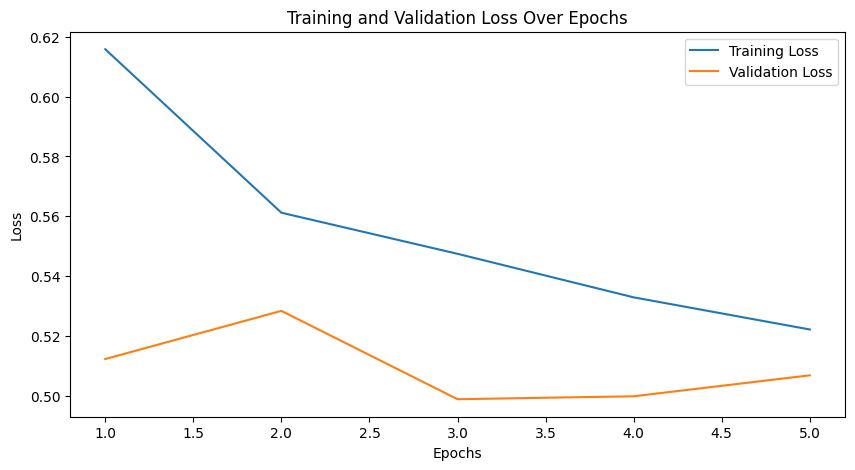

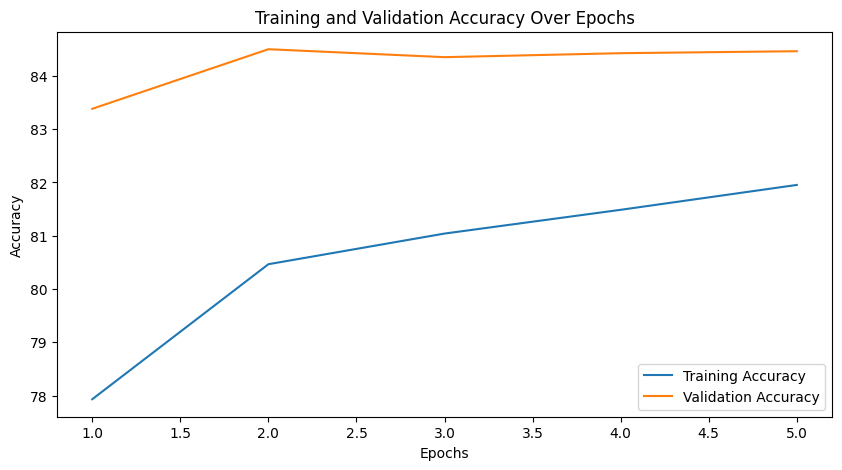

In [25]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc) + 1), train_acc, label="Training Accuracy")
plt.plot(range(1, len(val_acc) + 1), val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.show()

# Hyperparameter Tuning

For this I have decided to tune my model a little to provide better results. The following are the changes I have made as compare to model 1: 

1. Implement Early Stopping:
       Added an early_stop_counter to track epochs without validation loss improvement
       Stopped training after patience epochs of no improvement
2. Changed optimizer to SGD with a learning rate of 0.01 and momentum 0.9
3. Adding Regularization:
       Dropout: - Forces the network to learn redundant representations of the data.
                - Reduces the dependency of the model on specific neurons during training, improving generalization.
       Weight Decay: - Encourages smaller weights, which prevents the model from learning overly complex features that may not generalize well.


In [26]:
class PneumoniaModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")
        self.model.conv1 = nn.Conv2d(
            in_channels=1,  # Single-channel input as our images are greyscale
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
            bias=False
        )
        nn.init.kaiming_normal_(self.model.conv1.weight, mode="fan_out", nonlinearity="relu")
        
        # Fully connected layer with Dropout for regularization
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),  # Intermediate layer
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout with 50% probability
            nn.Linear(512, 1)  # Output layer for binary classification
        )

    def forward(self, x):
        return self.model(x)

In [27]:
# Training function
def train(epoch, model, train_loader, optimizer, loss_fn, device, train_losses, train_acc):
    model.train()
    correct = 0
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data).squeeze(1)
        loss = loss_fn(output, target.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(output) > 0.5).int()
        correct += preds.eq(target.int()).sum().item()

        # Print training progress every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

    # Compute metrics for the epoch
    accuracy = 100. * correct / len(train_loader.dataset)
    avg_loss = total_loss / len(train_loader)


    train_losses.append(avg_loss)
    train_acc.append(accuracy)

    print(f"Train Epoch: {epoch}, Average Loss: {avg_loss:.4f}, Accuracy: {correct}/{len(train_loader.dataset)} ({accuracy:.2f}%)")


# Evaluation function
def evaluate(model, val_loader, loss_fn, device, val_losses, val_acc):
    model.eval()
    test_loss = 0
    correct = 0


    predictions = []
    true_labels = []
    samples = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            output = model(data).squeeze(1)
            test_loss += loss_fn(output, target.float()).item()
            preds = torch.sigmoid(output) > 0.5  

            # Store predictions and corresponding data for visualization
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
            samples.extend(data.cpu().numpy())

            correct += preds.eq(target.int()).sum().item()

    # Compute metrics for the epoch
    test_loss /= len(val_loader)  # Average batch loss
    accuracy = 100. * correct / len(val_loader.dataset)

    
    val_losses.append(test_loss)
    val_acc.append(accuracy)

    print(f"\nValidation set: Average Loss: {test_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} "
          f"({accuracy:.2f}%)\n")

    return test_loss, accuracy, predictions, true_labels, samples



In [28]:
model2 = PneumoniaModel2().to(device)
optimizer2 = SGD(
    model2.parameters(), 
    lr=0.01, 
    momentum=0.9, 
    weight_decay=1e-4  # L2 Regularization (weight decay)
)
pos_weight2 = torch.tensor([2.0]).to(device)  # Adjust pos_weight for class imbalance
loss_fn2 = nn.BCEWithLogitsLoss(pos_weight=pos_weight2)

In [29]:
train_losses2 = []
val_losses2 = []
train_acc2 = []
val_acc2 = []

In [30]:
n_epochs2 = 10
patience = 3  # Stop if no improvement for 3 consecutive epochs
best_val_loss2 = float("inf")
early_stop_counter = 0

# Training and validation loop with early stopping
start_time = time.time()
predictions = []
true_labels = []
samples = []

for epoch in range(1, n_epochs2 + 1):
    train(epoch, model2, train_loader, optimizer2, loss_fn2, device, train_losses2, train_acc2)
    val_loss, val_acc_epoch, predictions, true_labels, samples = evaluate(model2, val_loader, loss_fn2, device, val_losses2, val_acc2)

    # Update early stopping counter if no improvement
    if val_loss < best_val_loss2:
        best_val_loss2 = val_loss
        early_stop_counter = 0  # Reset the counter
    else:
        early_stop_counter += 1
        print(f"Validation loss did not improve for {early_stop_counter} consecutive epoch(s).")

    # Check for early stopping
    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {early_stop_counter} epochs without improvement.")
        break

print("\nTraining Complete!")
print(f'\nDuration: {(time.time() - start_time) / 60:.2f} minutes')


Train Epoch: 1 [6336/24000 (26%)]	Loss: 0.679586
Train Epoch: 1 [12736/24000 (53%)]	Loss: 0.576288
Train Epoch: 1 [19136/24000 (80%)]	Loss: 0.724349
Train Epoch: 1, Average Loss: 0.6396, Accuracy: 18736/24000 (78.07%)

Validation set: Average Loss: 0.5553, Accuracy: 2207/2684 (82.23%)

Train Epoch: 2 [6336/24000 (26%)]	Loss: 0.758502
Train Epoch: 2 [12736/24000 (53%)]	Loss: 0.516317
Train Epoch: 2 [19136/24000 (80%)]	Loss: 0.588027
Train Epoch: 2, Average Loss: 0.5921, Accuracy: 19299/24000 (80.41%)

Validation set: Average Loss: 0.5154, Accuracy: 2208/2684 (82.27%)

Train Epoch: 3 [6336/24000 (26%)]	Loss: 0.485532
Train Epoch: 3 [12736/24000 (53%)]	Loss: 0.531923
Train Epoch: 3 [19136/24000 (80%)]	Loss: 0.620854
Train Epoch: 3, Average Loss: 0.5746, Accuracy: 19306/24000 (80.44%)

Validation set: Average Loss: 0.5365, Accuracy: 2158/2684 (80.40%)

Validation loss did not improve for 1 consecutive epoch(s).
Train Epoch: 4 [6336/24000 (26%)]	Loss: 0.646949
Train Epoch: 4 [12736/24000 (5

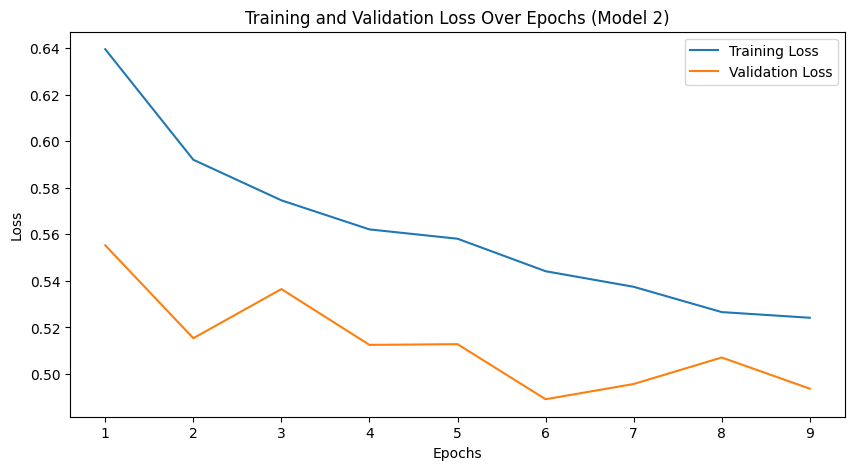

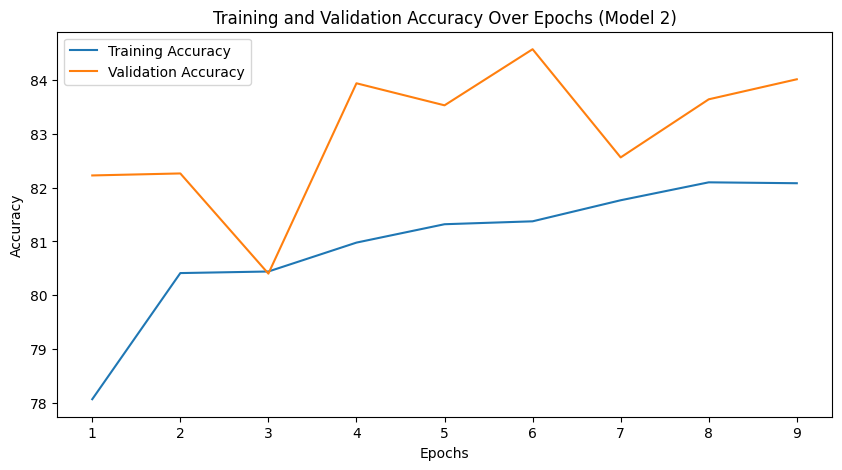

In [31]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses2) + 1), train_losses2, label="Training Loss")
plt.plot(range(1, len(val_losses2) + 1), val_losses2, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs (Model 2)")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc2) + 1), train_acc2, label="Training Accuracy")
plt.plot(range(1, len(val_acc2) + 1), val_acc2, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs (Model 2)")
plt.legend()
plt.show()

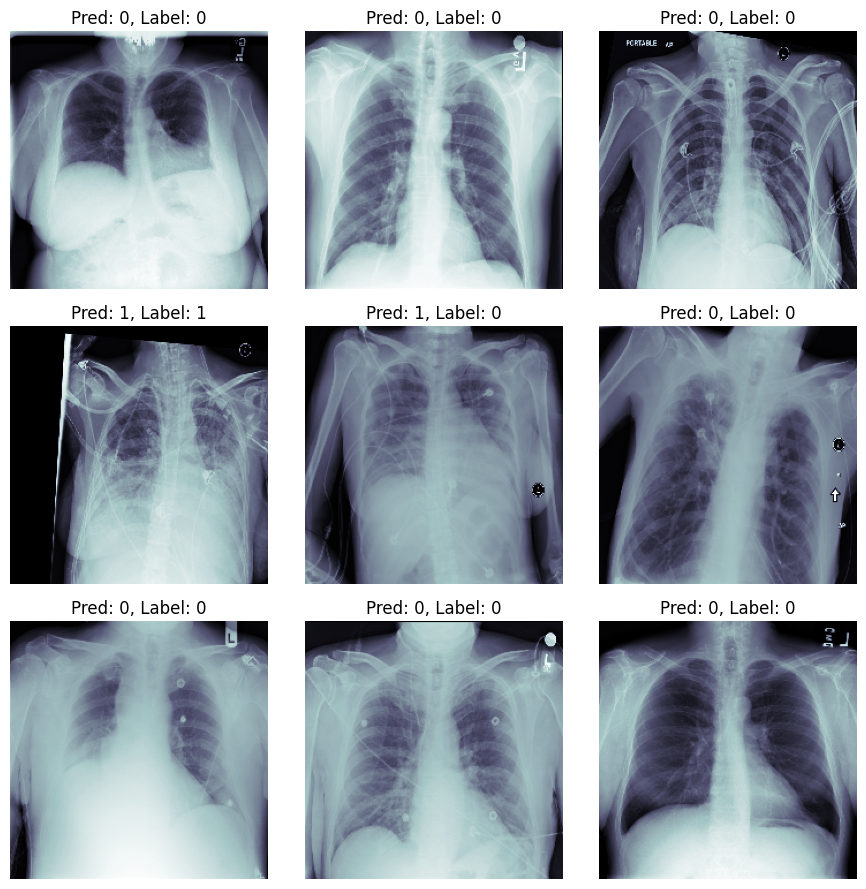

In [32]:
# Visualization: Random predictions with corresponding labels
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(predictions))  # Randomly pick an index
        sample = samples[rnd_idx]  # Get the sample data
        pred = int(predictions[rnd_idx])  # Get the predicted label
        label = int(true_labels[rnd_idx])  # Get the true label

        axis[i][j].imshow(sample[0], cmap="bone")  # Show X-ray image (grayscale)
        axis[i][j].set_title(f"Pred: {pred}, Label: {label}")
        axis[i][j].axis("off")  # Hide axis

plt.tight_layout()
plt.show()

# To implement CMAP 

A visualisation in Matplotlib that specifies how data values are mapped to colors in a plot. It is particularly useful for heatmaps, images, and overlays. In our pneumonia detection, cmap="bone" is used for X-ray images to maintain their grayscale format, while cmap="jet" overlays heatmaps to highlight areas of interest (e.g., regions the model associates with pneumonia). This enhances interpretability by contrasting the activation map with the original image.


In [33]:
class PneumoniaModel3(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")
        self.model.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
            bias=False
        )
        nn.init.kaiming_normal_(self.model.conv1.weight, mode="fan_out", nonlinearity="relu")

        # Extract feature maps from the penultimate layer
        self.features = nn.Sequential(*list(self.model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling as in ResNet
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        # Compute features and class predictions
        feature_map = self.features(x)
        pooled = self.avgpool(feature_map)
        flat = self.flatten(pooled)
        pred = self.fc(flat)
        return pred, feature_map


In [34]:
def cam(model, img):
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    
    # Extract weights from the first fully connected layer
    weight_params = list(model.fc.parameters())[0]
    weight = weight_params[0].detach()  # Detach to prevent gradient computation
    
    # Compute weighted sum of feature maps
    b, c, h, w = features.shape
    features = features.reshape((c, h * w))  # Flatten spatial dimensions
    cam = torch.matmul(weight, features).reshape(h, w)  # Weighted sum
    cam = cam - cam.min()  # Normalize
    cam = cam / cam.max()
    return cam.cpu(), torch.sigmoid(pred)


In [35]:
def visualize(img, cam, pred):
    img = img[0]  # Select the single-channel image
    cam_resized = F.resize(cam.unsqueeze(0), (img.shape[0], img.shape[1]))[0]  # Resize CAM to match the image

    # Plot original and overlayed CAM
    fig, axis = plt.subplots(1, 2, figsize=(10, 5))
    axis[0].imshow(img, cmap="bone")
    axis[0].set_title("Original Image")

    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam_resized, alpha=0.5, cmap="jet")
    axis[1].set_title(f"Pneumonia Prediction: {int(pred > 0.5)}")
    plt.show()

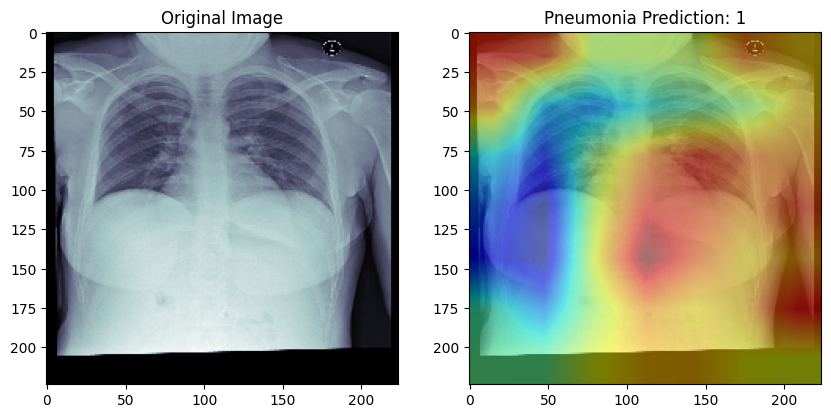

In [36]:
# Instantiate PneumoniaModel3
model3 = PneumoniaModel3().to(device)

# Pick a validation sample
img, label = val_dataset[0]  # Get the first sample from validation dataset
img = img.to(device)

# Compute CAM
activation_map, pred = cam(model3, img)

# Visualize the CAM overlay
visualize(img.cpu(), activation_map, pred)